In [14]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from math import factorial
from scipy.special import logsumexp
# Thank you Bastian for letting me use your ipynb as """inspiration"""
# Update: At this point, it looks nothing alike.
    

In [42]:
class State():

    '''
    I've named the attributes and operations mostly according to the paper's naming scheme.
    I did change a few names here and there because I like it this way more.
    '''    
    def __init__(self, num_modes = 1, hbar = 2):
        """
        Initialize the states. Vacuum state by default
        
        Parameters
        -----------
        num_modes: Number of modes that the state has. Single (1) mode by default
        
        hbar: Planck's constant. hbar = 1 by default.
        """
        self.hbar = hbar
        self.num_modes = num_modes                                         # Me being ambitious and set an arbitrary # of modes. We'll prolly stick to 1
        self.means = np.array(np.zeros(self.num_modes*2))                  # Mean of the state, mu. zero'd by default. [x_i, p_i]
        self.covs = np.array(np.eye(self.num_modes*2)) * self.hbar/2       # Covariance matrix of the state. hbar/2 * I by default
        self.weights = np.array([1])                                       # It's just a single state by default
        self.log_weights = np.array([0])                                   # Take the ln of the weights. so zero
        self.num_weights = len(self.weights)                               # Number of weights. Used for size (the sum index k needs it, I think)
        self.num_k = self.num_weights                                      # Olga had this so I'll include it now and see how to use it later
        self.covDet = np.linalg.det(2*np.pi*self.covs)                     # Storing it beforehand so it's faster to calc.
        self.covInv = np.linalg.inv(self.covs)                             # Same as above
        self.norm = 1                                                      # I thought i didn't need it because "duh obviously it'll be normalized". Turns out not necessarily
        #self.psi = np.zeros((1,)*num_modes)                               # Tracking the states that we have in the Fock basis? Vacuum by default

    def Update(self, data):
        """
        data = [means, covs, log_weights, num_k]
        """
        if len(data) != 4:
            raise ValueError('Oops, you done fucked up now. It should be exact FOUR values. ')
        
        self.means, self.covs, self.log_weights, self.num_k = data
        self.num_weights = len(self.weights)
        self.num_modes = int(np.shape(self.means)[-1]/2)
        self.weights = np.exp(self.log_weights)
    

    def normalize(self):
        """
        Normalizes the state.
        """
        # Ensure log_weights is float type
        self.log_weights = self.log_weights.astype(np.float64)
        
        # Calculate norm using logsumexp
        log_norm = logsumexp(self.log_weights)
        
        # Normalize weights
        if self.num_k != self.num_weights:
            self.log_weights -= np.log(self.norm)
        else:
            self.log_weights -= log_norm
        
        # Update norm attributes
        if self.num_k != self.num_weights:
            self.log_norm = log_norm
            self.norm = np.exp(log_norm).real
        else:   
            self.log_norm = log_norm
            self.norm = np.real_if_close(np.exp(log_norm))
        
        self.weights = np.exp(self.log_weights)
        
        return self

    def ApplyOp(self, F, d, mode_indices=None):
        """
        Applies an operation to specified modes
        Parameters
        ----------
        F : array_like
            Symplectic matrix (2x2 for single mode, 2Nx2N for multi-mode)
        d : array_like
            Displacement vector
        mode_indices : int or list, optional
            Index/indices of modes to apply operation to (None = all modes)
        """
        if mode_indices is None:
            # Original behavior - apply to all modes
            self.covs = F @ self.covs @ F.T
            self.means = F @ self.means + d
        else:
            # Convert single index to list if needed
            if isinstance(mode_indices, int):
                mode_indices = [mode_indices]
            
            # Create full transformation matrix
            full_F = np.eye(2*self.num_modes)
            full_d = np.zeros(2*self.num_modes)
            
            # For each target mode, embed its operation
            for i in mode_indices:
                start, end = 2*i, 2*(i+1)
                full_F[start:end, start:end] = F
                full_d[start:end] = d
                
            # Apply the embedded operation
            self.covs = full_F @ self.covs @ full_F.T
            self.means = full_F @ self.means + full_d
    
        # Update cached properties
        self.covInv = np.linalg.inv(self.covs)
        self.covDet = np.linalg.det(2*np.pi*self.covs)
            

    def Gaussian(self, x, p):
        X, P = np.meshgrid(x, p)
        grid_points = np.vstack([X.ravel(), P.ravel()]).T
        factor = 1/np.sqrt(self.covDet)
        diff = grid_points - self.means
        exponent = -0.5 * np.einsum('ni,ij,nj->n', diff, self.covInv, diff)
        return factor*np.exp(exponent).reshape(X.shape)
    

    def ApplyLoss(self, etas, nbars):
        """
        Applies loss channels to each mode individually
        
        Parameters
        ------------
        etas (array): Transmittivities for each mode (0 < eta ≤ 1)
        nbars (array): Thermal photon numbers for each mode
        """

        n_etas = len(etas)
        n_nbars = len(nbars)
        if n_etas != self.num_modes or n_nbars != self.num_modes:
            raise ValueError("Number of etas and nbars must match num_modes")
        
        for i in range(self.num_modes):
            # Create single-mode loss transformation
            X_i = np.sqrt(etas[i]) * np.eye(2)
            Y_i = (self.hbar/2) * (1-etas[i]) * (2*nbars[i] + 1) * np.eye(2)
            
            # Apply to each mode using your existing infrastructure
            self.ApplyOp(X_i, np.zeros(2), mode_indices=i)
            
            # Add noise term directly to the covariance matrix
            start, end = 2*i, 2*i+2
            self.covs[start:end, start:end] += Y_i
    
    def ApplyGain(self, G):
        """
        It's like applying loss but slightly different
        """
        n_G = len(G)
        if n_G != self.num_modes:
            raise ValueError("Number of etas and nbars must match num_modes")
        
        for i in range(self.num_modes):
            # Create single-mode gain transformation
            X_i = np.sqrt(G[i]) * np.eye(2)
            Y_i = (self.hbar/2) * (G[i]-1) * np.eye(2)
            
            # Apply to each mode using your existing infrastructure
            self.ApplyOp(X_i, np.zeros(2), mode_indices=i)
            
            # Add Gain term directly to the covariance matrix
            start, end = 2*i, 2*i+2
            self.covs[start:end, start:end] += Y_i


    def removeMode(self, mode_index):
        """
        Written by DeepSeek

        Removes a specified mode from the Gaussian state representation
            
        Parameters:
            mode_index (int): Index of mode to remove (0-based)
                
        Returns:
            None (updates state in-place)
        """
        if mode_index >= self.num_modes:
            raise ValueError(f"Mode index {mode_index} exceeds number of modes ({self.num_modes})")
        
        # Indices to keep (in xxpp ordering)
        keep_indices = []
        for i in range(self.num_modes):
            if i != mode_index:
                keep_indices.extend([2*i, 2*i+1])  # Keep both x and p of this mode
        
        # Update covariance matrix
        self.covs = self.covs[np.ix_(keep_indices, keep_indices)]
        
        # Update means vector
        self.means = self.means[keep_indices]
        
        # Update state properties
        self.num_modes -= 1
        self.covInv = np.linalg.inv(self.covs)
        self.covDet = np.linalg.det(2*np.pi*self.covs)
    

    def post_select_fock(self, mode, n, infidelity=1e-4, out= False ):
        """
        Simplified Fock state projection measurement on a specified mode.
        Returns the post-measurement state and measurement probability.
        
        Parameters
        ----------
            mode : Mode index to measure (starts from 0!)
            n : Number of photons to project onto
            infidelity : Approximation tolerance for Fock state
            
        Returns:
            float: Measurement probability
        """
        # Convert from Fock to Coherent
        means_n, w_kl, num_k = Fock2Coh(N=n, prox=infidelity, hbar=self.hbar)
        weights_n = np.exp(w_kl)
        weights_n = np.sum(weights_n)
        
        # Defining our sigma_A, sigma_B, and Sigma_AB
        measured_indices = [2*mode, 2*mode+1]
        remaining_indices = [i for i in range(2*self.num_modes) if i not in measured_indices]
        
        sigma_AA = self.covs[np.ix_(remaining_indices, remaining_indices)]
        sigma_AB = self.covs[np.ix_(remaining_indices, measured_indices)]
        sigma_BB = self.covs[np.ix_(measured_indices, measured_indices)]
        mu_A = self.means[remaining_indices]
        mu_B = self.means[measured_indices]

        # Compute conditional state for each |α><α| term
        new_means = []
        new_covs = []
        probs = []
        
        for alpha_mean, alpha_weight in zip(means_n, weights_n):
            # Conditional mean
            C = sigma_BB + (self.hbar/2)*np.eye(2)
            C_inv = np.linalg.inv(C)

            # Conditional means eq. (29)
            new_mu = mu_A + sigma_AB @ C_inv @ (alpha_mean - mu_B)
            
            # Conditional covariance eq. (26)
            new_sigma = sigma_AA - sigma_AB @ C_inv @ sigma_AB.T
            
            # Gaussian distr.
            diff = alpha_mean - mu_B
            prob = alpha_weight * np.exp(-0.5 * diff.T @ C_inv @ diff) / np.sqrt(np.linalg.det(2*np.pi*C))
            
            new_means.append(new_mu)
            new_covs.append(new_sigma)
            probs.append(prob)
        
        # Combining the results
        total_prob = np.sum(probs)
        combined_mu = np.sum([p*m for p,m in zip(probs, new_means)], axis=0) / total_prob
        combined_sigma = np.sum([p*s for p,s in zip(probs, new_covs)], axis=0) / total_prob
        
        data = [combined_mu, combined_sigma, w_kl, len(w_kl)]
        self.Update(data)
        
        # Copied this from Olga's code since I think it's pretty neat to have.
        if out:
            print(f'Measuring {n} photons in mode {mode}.')
            print(f'Data shape before measurement, {[i.shape for i in data_in[0:2]]}.')
            print('Probability of measurement = {:.3e}'.format(self.norm))
            print(f'Data shape after measurement, {[i.shape for i in data_out[0:2]]}')

        return total_prob



In [31]:
# Slightly more generic functions. NOT operations on state object specifically.
def indices(N):
    """
    Generates the indexes k and l
    So that I don't have to write a double for loop everytime 
    """
    max = N+1
    k, l = np.triu_indices(max,1)
    k = np.concatenate([range(max),k])
    l = np.concatenate([range(max),l])

    return k, l

def Fock2Coh(N, prox, epsilon = None, hbar = 2):
    """
     Written by me (I'm serious) (With some inspiration from Olga)
        
    Converts from Fock state to a superposition of Gaussian states
    Follows eq. (18) and eq. (19) from Olga Solodovnikova

    Parameters
    -----------
    N - Fock number state
    prox - For estimating parameter epsilon. Follows eq. (44)
    """
    cov = 0.5*hbar*np.eye(2)
    factor = 2*1j*np.pi/(N+1)
    k, l = indices(N)

    # From the paragraph after eq. (44), about how F scales with epsilon
    if not epsilon:
        epsilon = ( factorial(2*N + 1)/ (N*prox) ) **(0.5*(N+1))

    alpha_k = epsilon * np.exp( factor * k )
    alpha_l = epsilon * np.exp( factor * l)

    sum_states = alpha_k + alpha_l
    diff_states = alpha_k + alpha_l
    mu = np.sqrt(hbar/2) * np.array([
            sum_states.real + 1j*diff_states.imag,
            sum_states.imag + 1j*(-diff_states.real)
        ])
    d_kl = ( -0.5*diff_states.imag**2 - 0.5*diff_states.real**2
                  - 1j*alpha_l.imag*alpha_k.real + 1j*alpha_k.imag*alpha_l.real)
    w_kl = d_kl - factor * N * (k-l)

    # Number of terms in the first sum in eq. 21
    num_k = N + 1
    
    # Normalization constant
    #N = np.sum(np.exp(w_kl))
    # Commented because I figured it's more useful to store w_kl
    return mu.T, cov, w_kl, num_k


def prepare_fock_coherent(n, prox=1e-4, epsilon = None):
    """
    Prepare Fock state in coherent state approx
    """

    data = Fock2Coh(n, prox, epsilon)
    fock = State(1)
    fock.Update(data)
    return fock

In [5]:
# Our (X,P) grid
x = np.linspace(-5, 5, 100)
p = np.linspace(-5, 5, 100)

X, P = np.meshgrid(x, p)

# Squeezing Op.
def Sqz(r,theta):
    return np.cosh(r) * np.eye(2) + np.sinh(r) * np.array([[np.cos(theta), np.sin(theta)], [np.sin(theta), -np.cos(theta)]])
d_squeezing = np.zeros(2)  # No displacement for squeezing

# Displacement Op.
F_Displacement = np.eye(2)
def Displacement(alpha):
    return np.array([alpha.real, alpha.imag])

In [6]:
test = State(2)
#test.ApplyOp(Sqz(0.8,0),d_squeezing)
#W = test.Gaussian(x,p)
#test.ApplyOp(Sqz(0.8,0), d_squeezing, mode_indices=1)
test.removeMode(1)
test.covs

array([[1., 0.],
       [0., 1.]])

In [43]:
# Initialize state
test = State(2)

# Convert inputs to NumPy arrays before passing
etas = np.array([0.7, 0.5])  # <-- Convert to NumPy array
nbars = np.array([3, 3])     # <-- Convert to NumPy array
G = np.array([2, 2])
test.ApplyLoss(etas, nbars)  
test.removeMode(0)
test.normalize()
test.covs

array([[4., 0.],
       [0., 4.]])

In [ ]:
N = 5
epsilon = 0.5
state = prepare_fock_coherent(N, 1, epsilon)
#state.normalize()
#state.covs

Fock2Coh(N, 1, epsilon)

(array([[ 5.08811761e+20+0.00000000e+00j,  0.00000000e+00-5.08811761e+20j],
        [ 2.54405880e+20+4.40643911e+20j,  4.40643911e+20-2.54405880e+20j],
        [-2.54405880e+20+4.40643911e+20j,  4.40643911e+20+2.54405880e+20j],
        [-5.08811761e+20+6.23114694e+04j,  6.23114694e+04+5.08811761e+20j],
        [-2.54405880e+20-4.40643911e+20j, -4.40643911e+20+2.54405880e+20j],
        [ 2.54405880e+20-4.40643911e+20j, -4.40643911e+20-2.54405880e+20j],
        [ 3.81608821e+20+2.20321955e+20j,  2.20321955e+20-3.81608821e+20j],
        [ 1.27202940e+20+2.20321955e+20j,  2.20321955e+20-1.27202940e+20j],
        [ 0.00000000e+00+3.11557347e+04j,  3.11557347e+04+0.00000000e+00j],
        [ 1.27202940e+20-2.20321955e+20j, -2.20321955e+20-1.27202940e+20j],
        [ 3.81608821e+20-2.20321955e+20j, -2.20321955e+20-3.81608821e+20j],
        [ 8.19200000e+04+4.40643911e+20j,  4.40643911e+20-8.19200000e+04j],
        [-1.27202940e+20+2.20321955e+20j,  2.20321955e+20+1.27202940e+20j],
        [-8.

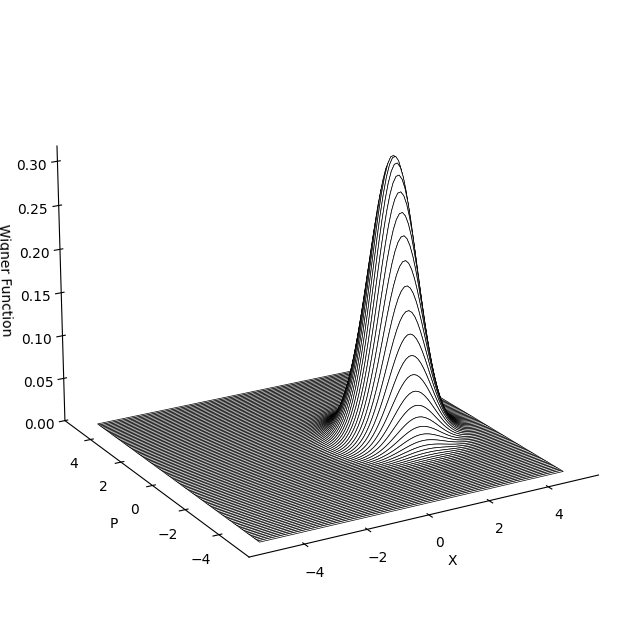

In [44]:
# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the Wigner function
ax.plot_surface(X, P, W, rstride=1, cstride=100000, color='w', edgecolor='k', shade=False, lw=.5, alpha=1)

# Customize the plot
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.grid(False)

# Set labels and limits
ax.set_xlabel('X')
ax.set_ylabel('P')
ax.set_zlabel('Wigner Function')
ax.set_zlim(np.min(W), np.max(W))
ax.view_init(20, -120)  # Adjust the viewing angle

plt.show()